In [1]:
from dipy.data import get_sphere
from microstruktur.signal_models import distributions
import numpy as np
from dipy.reconst.shm import real_sym_sh_mrtrix
import matplotlib.pyplot as plt
%matplotlib inline 
watson = distributions.SD1Watson()

# Test what spherical harmonic order is needed to represent a watson distribution for a certain concentration kappa

In [3]:
# estimate what spherical harmonic order is sufficient for a certain kappa
mu = np.r_[0., 0.]
kappas = np.linspace(0, 16, 100)
sh_orders = np.arange(2, 15, 2)

error_results = np.zeros((len(kappas), len(sh_orders)))
sphere = get_sphere().subdivide()

for i, kappa in enumerate(kappas):
    for j, sh_order in enumerate(sh_orders):
        watson_sf = watson(sphere.vertices, mu=mu, kappa=kappa)
        sh_mat = real_sym_sh_mrtrix(sh_order, sphere.theta, sphere.phi)[0]
        sh_mat_inv = np.linalg.pinv(sh_mat)
        watson_sh = np.dot(sh_mat_inv, watson_sf)
        watson_rec = np.dot(sh_mat, watson_sh)
        error_results[i, j] = max(np.abs(watson_sf - watson_rec) / max(watson_sf))

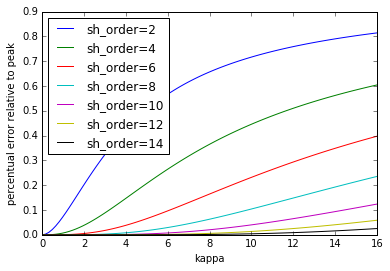

In [4]:
for i, sh_order in enumerate(sh_orders):
    plt.plot(kappas, error_results[:, i],
             label='sh_order=' + str(sh_order))
plt.title('Fitting error watson')
plt.xlabel('kappa')
plt.ylabel('percentual error relative to peak')
plt.legend(loc='upper left')

In [5]:
sh_order_kappas = kappas[np.argmax(error_results > 0.02, axis=0)]
sh_order_kappas

array([  0.48484848,   1.61616162,   3.23232323,   5.33333333,
         8.08080808,  11.31313131,  15.03030303])

In [6]:
def get_sh_order_from_kappa(kappa):
    kappas = np.r_[3.23232323, 5.33333333,
                   8.08080808,  11.31313131,  np.inf]
    sh_orders = np.arange(6, 15, 2)
    return sh_orders[np.argmax(kappas > kappa)]

# What spherical harmonics order is needed to represent the data for a certain b-value. Worst case anisotropy is the stick.

In [10]:
from microstruktur.signal_models import cylinder_models
from microstruktur.core import acquisition_scheme

In [12]:
bvecs = sphere.vertices
big_delta = 0.03
small_delta = 0.01

In [18]:
# worst case scenario, completely free parallel and completely restricted perpendicular
dpar = 3e-9
stick1 = cylinder_models.C1Stick(mu=np.r_[0., 0.], lambda_par=dpar)
stick2 = cylinder_models.C1Stick(mu=np.r_[np.pi / 2., 0.], lambda_par=dpar)

In [27]:
sh_orders = np.arange(2, 15, 2)
bvals_list = np.linspace(0, 1e10, 100)

error_results_stick = np.zeros((len(bvals_list), len(sh_orders)))

for i, bval in enumerate(bvals_list):
    for j, sh_order in enumerate(sh_orders):
        bvals = np.tile(bval, len(bvecs))
        scheme = acquisition_scheme.acquisition_scheme_from_bvalues(
            bvalues=bvals, gradient_directions=bvecs, Delta=big_delta, delta=small_delta)
        stick_sf = 0.5 * (stick1(scheme) + stick2(scheme))
        sh_mat = real_sym_sh_mrtrix(sh_order, sphere.theta, sphere.phi)[0]
        sh_mat_inv = np.linalg.pinv(sh_mat)
        stick_sh = np.dot(sh_mat_inv, stick_sf)
        stick_rec = np.dot(sh_mat, stick_sh)
        error_results_stick[i, j] = max(np.abs(stick_sf - stick_rec) / max(stick_sf))

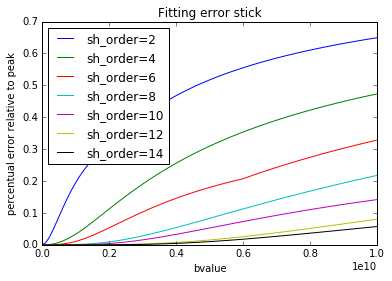

In [28]:
for i, sh_order in enumerate(sh_orders):
    plt.plot(bvals_list, error_results_stick[:, i],
             label='sh_order=' + str(sh_order))
plt.title('Fitting error stick')
plt.xlabel('bvalue')
plt.ylabel('percentual error relative to peak')
plt.legend(loc='upper left')

In [34]:
sh_order_bval = bvals_list[np.argmax(error_results_stick > 0.02, axis=0)]
sh_order_bval

array([  2.02020202e+08,   8.08080808e+08,   1.31313131e+09,
         2.72727273e+09,   3.33333333e+09,   5.55555556e+09,
         6.36363636e+09])

In [35]:
def get_sh_order_from_bval(bval):
    bvals = np.r_[1.31313131e+09, 2.72727273e+09, 3.33333333e+09,
                  5.55555556e+09, np.inf]
    sh_orders = np.arange(6, 15, 2)
    return sh_orders[np.argmax(bvals > bval)]

In [38]:
get_sh_order_from_bval(1e9)

6